# Visualize the potential function for drone collision avoidance

Import modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import colormaps
from scipy.spatial.transform import Rotation

# Comment this line out unless you have already installed "pympl" in your conda environment
%matplotlib widget

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Define a function to get the following things, assuming our method of collision avoidance is based on the use of artificial potential fields:
* `pdes` - the desired position
* `h` - the value of the potential function
* `grad_h` - the gradient of the potential function
* `h_att` - the value of the attractive part of the potential function
* `grad_h_att` - the gradient of the attractive part of the potential function
* `h_rep` - the value of the repulsive part of the potential function
* `grad_h_rep` - the gradient of the repulsive part of the potential function

In [2]:
def get_potential_field(phat, pos_ring, dir_ring, pos_others, k_att=1., k_rep=1., k_des=1., r_drone=0.25, r_ring=1., emax=1.):

    ##############################
    # Choose goal
    # - Example: exactly at the center of the next ring
    pgoal = pos_ring
    # # - Example: some distance beyond the next ring
    # pgoal = pos_ring + 1. * dir_ring

    ##############################
    
    # Get attractive part
    h_att = k_att * np.linalg.norm(phat - pgoal)
    if np.isclose(h_att, 0.):
        grad_h_att = 0.
    else:
        grad_h_att = k_att * (phat - pgoal) / np.linalg.norm(phat - pgoal)
    
    # Get repulsive part
    
    # - Initialize
    h_rep = 0.
    grad_h_rep = np.zeros(3)
    
    # - Add repulsive part for each other drone
    for q in pos_others:
        pobst = q + r_drone * ((phat - q) / np.linalg.norm(phat - q))
        d = np.linalg.norm(phat - pobst) - r_drone
        if d <= 0:
            h_rep += np.inf
            grad_h_rep += np.zeros(3)
        else:
            dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
            h_rep += k_rep * (1 / d)
            grad_h_rep += - k_rep * (1 / d**2) * dgrad
    
    # - Add repulsive part for next ring
    s = r_ring
    n = dir_ring
    q = pos_ring
    v_n = (n.dot(phat - q)) * n
    v_t = (phat - q) - v_n
    if np.isclose(np.linalg.norm(v_t), 0.):
        d = np.sqrt(np.linalg.norm(v_n)**2 + r_ring**2) - r_drone
        if np.isclose(np.linalg.norm(v_n), 0.):
            dgrad = np.zeros(3)
        else:
            dgrad = v_n / np.linalg.norm(v_n)
    else:
        if np.linalg.norm(v_t) > s:
            pobst = q + v_t
        else:
            pobst = q + s * (v_t / np.linalg.norm(v_t))
        d = np.linalg.norm(phat - pobst) - r_drone
        dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
    if d <= 0:
        h_rep = +np.inf
        grad_h_rep += np.zeros(3)
    else:
        h_rep += k_rep * (1 / d)
        grad_h_rep += - k_rep * (1 / d**2) * dgrad
    
    # - Add repulsive part for ground
    n = np.array([0., 0., 1.])
    q = np.array([0., 0., 0.])
    pobst = phat - (n.dot(phat - q)) * n
    d = np.linalg.norm(phat - pobst) - r_drone
    dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
    if d <= 0:
        h_rep = +np.inf
        grad_h_rep += np.zeros(3)
    else:
        h_rep += k_rep * (1 / d)
        grad_h_rep += - k_rep * (1 / d**2) * dgrad
    
    # Get total
    h = h_att + h_rep
    if np.isinf(h):
        grad_h = np.zeros(3)
    else:
        grad_h = grad_h_att + grad_h_rep

    # Get desired position
    pdes = phat - k_des * grad_h
    
    ##############################
    
    # Make sure desired position is not too far away
    if np.linalg.norm(pdes - phat) > emax:
        pdes = phat + emax * ((pdes - phat) / np.linalg.norm(pdes - phat))
    
    return pdes, h, grad_h, h_att, grad_h_att, h_rep, grad_h_rep

Define a function to evaluate the potential field at many different points, so we can later create a contour plot.

In [3]:
def evaluate_potential_field(x_lim, y_lim, n, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax):
    x = np.linspace(x_lim[0], x_lim[1], n)
    y = np.linspace(y_lim[0], y_lim[1], n)
    z = 1.
    X, Y = np.meshgrid(x, y)
    H = np.zeros_like(X)
    for ix in range(n):
        for iy in range(n):
            pdes, h, grad_h, h_att, grad_h_att, h_rep, grad_h_rep = get_potential_field(
                np.array([X[ix, iy], Y[ix, iy], z]),
                pos_ring,
                dir_ring,
                pos_others,
                k_att=k_att,
                k_rep=k_rep,
                k_des=k_des,
                r_drone=r_drone,
                r_ring=r_ring,
                emax=emax,
            )
            H[ix, iy] = h
    
    return X, Y, H

Define a function to plot the potential field.

In [4]:
def plot_potential_field(X, Y, H, x_lim, y_lim, phat, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    cmap = colormaps['inferno']
    levels = k_rep * np.concatenate([np.linspace(0., 10., 21), np.linspace(20., 100., 3)])
    colors = cmap(np.concatenate([np.linspace(0, 0.9, 21), np.linspace(0.9, 1.0, 3)]))
    CS = ax.contour(X, Y, H, levels=levels, colors=colors)

    ax.clabel(CS, fontsize=12)
    CB = fig.colorbar(CS, shrink=0.8)

    pdes, h, grad_h, h_att, grad_h_att, h_rep, grad_h_rep = get_potential_field(
        phat,
        pos_ring,
        dir_ring,
        pos_others,
        k_att=k_att,
        k_rep=k_rep,
        k_des=k_des,
        r_drone=r_drone,
        r_ring=r_ring,
        emax=emax,
    )

    (x, y, z) = phat
    ax.plot(x, y, '.', markersize=12, color='C0', zorder=10)
    ax.add_patch(Circle((x, y), r_drone, color='C9'))
    ax.arrow(x, y, -k_des * grad_h[0], -k_des * grad_h[1], width=0.04, color='C0', zorder=10)

    for q in pos_others:
        (x, y, z) = q
        ax.add_patch(Circle((x, y), r_drone, color='k'))

    t = Rotation.from_rotvec((np.pi / 2) * np.array([0., 0., 1.])).as_matrix() @ dir_ring
    q = pos_ring
    ax.plot(
        [q[0] + r_ring * t[0], q[0] + (10 * r_ring) * t[0]],
        [q[1] + r_ring * t[1], q[1] + (10 * r_ring) * t[1]],
        '-',
        linewidth=3,
        color='k',
    )
    ax.plot(
        [q[0] - r_ring * t[0], q[0] - (10 * r_ring) * t[0]],
        [q[1] - r_ring * t[1], q[1] - (10 * r_ring) * t[1]],
        '-',
        linewidth=3,
        color='k',
    )

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_aspect('equal')

    return fig, ax

Define a function to get the trajectory that would be followed by gradient descent.

In [5]:
def get_trajectory(x_lim, y_lim, phat, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax, tol=1e-3, max_iter=100):
    p = phat.copy().reshape(1,-1).tolist()
    cur_iter = 0
    while True:
        cur_iter += 1
        if cur_iter > max_iter:
            print('WARNING: maximum number of iterations exceeded')
            break
        pdes, h, grad_h, h_att, grad_h_att, h_rep, grad_h_rep = get_potential_field(
            np.array(p[-1]),
            pos_ring,
            dir_ring,
            pos_others,
            k_att=k_att,
            k_rep=k_rep,
            k_des=k_des,
            r_drone=r_drone,
            r_ring=r_ring,
            emax=emax,
        )
        p.append(pdes.tolist())
        if np.linalg.norm(np.array(p[-1]) - np.array(p[-2])) < tol:
            break
        x, y, z = p[-1]
        if x < x_lim[0] or x > x_lim[1]:
            break
        if y < y_lim[0] or y > y_lim[1]:
            break
    return np.array(p)

Choose parameters and show an annotated contour plot of the corresponding potential field.

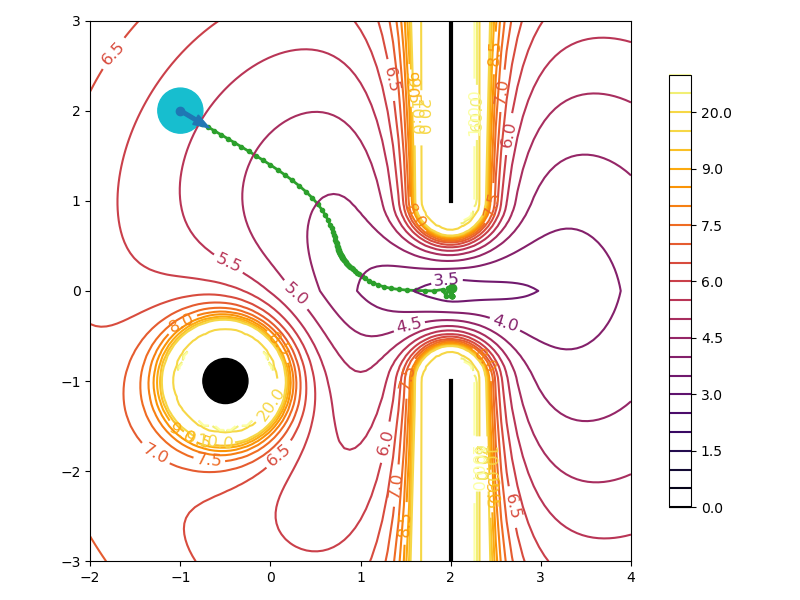

In [ ]:
# Position of drone
phat = np.array([-1., 2., 1.])

# Position and direction of next ring
pos_ring = np.array([2., 0., 1.])
dir_ring = np.array([1., 0., 0.])

# Position of other drones
# - Example: no other drones
pos_others = []
# - Example: one other drone
pos_others = [np.array([-0.5, -1., 1.])]

# Parameters
k_att=10.
k_rep=1.
k_des=0.25
emax_func = 1.00   # <-- used only when getting the potential field
emax_traj = 0.10   # <-- used only when getting the trajectory (for the purpose of illustration)

# Physical constants
r_ring = 1.
r_drone = 0.25

# Resolution with which to sample the potential field
n = 101
x_lim = [-2., 4.]
y_lim = [-3., 3.]

# Evaluate potential field at many different points
X, Y, H = evaluate_potential_field(x_lim, y_lim, n, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax_func)

# Show an annotated contour plot of the potential field
fig, ax = plot_potential_field(X, Y, H, x_lim, y_lim, phat, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax_func)

# Show trajectory that would be followed by gradient descent
p = get_trajectory(x_lim, y_lim, phat, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax_traj)
ax.plot(p[:, 0], p[:, 1], '.-', color='C2', linewidth=2, zorder=0)
ax.plot(p[-1, 0], p[-1, 1], '.', color='C2', markersize=12)
fig.tight_layout()

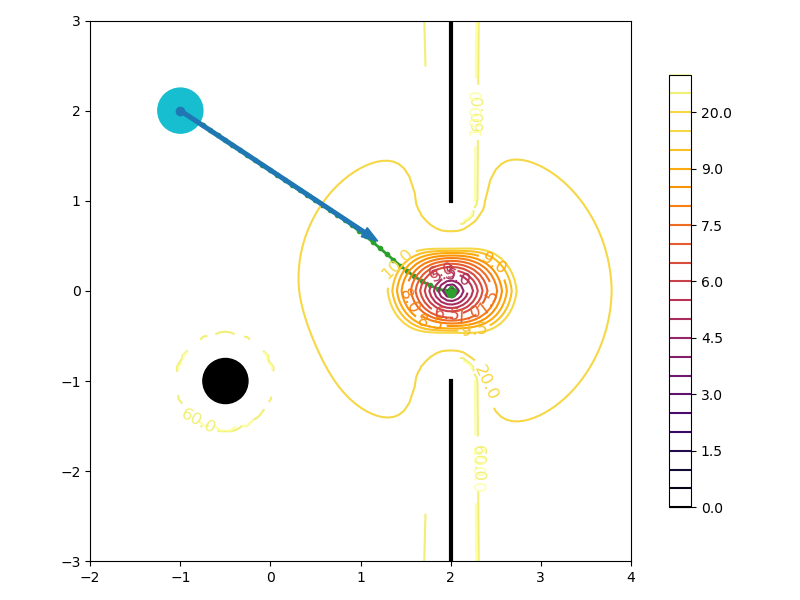

In [ ]:
# Position of drone
phat = np.array([-1., 2., 1.])

# Position and direction of next ring
pos_ring = np.array([2., 0., 1.])
dir_ring = np.array([1., 0., 0.])

# Position of other drones
# - Example: no other drones
pos_others = []
# - Example: one other drone
pos_others = [np.array([-0.5, -1., 1.])]

# Parameters
k_att=10.
k_rep=1.
k_des=0.25
emax_func = 1.00   # <-- used only when getting the potential field
emax_traj = 0.10   # <-- used only when getting the trajectory (for the purpose of illustration)

# Physical constants
r_ring = 1.
r_drone = 0.25

# Resolution with which to sample the potential field
n = 101
x_lim = [-2., 4.]
y_lim = [-3., 3.]

# Evaluate potential field at many different points
X, Y, H = evaluate_potential_field(x_lim, y_lim, n, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax_func)

# Show an annotated contour plot of the potential field
fig, ax = plot_potential_field(X, Y, H, x_lim, y_lim, phat, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax_func)

# Show trajectory that would be followed by gradient descent
p = get_trajectory(x_lim, y_lim, phat, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax_traj)
ax.plot(p[:, 0], p[:, 1], '.-', color='C2', linewidth=2, zorder=0)
ax.plot(p[-1, 0], p[-1, 1], '.', color='C2', markersize=12)
fig.tight_layout()

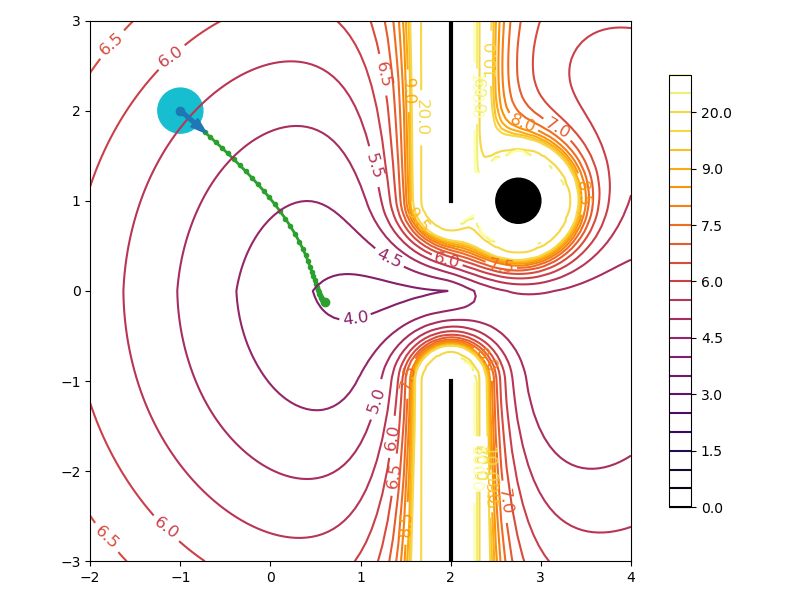

In [19]:
# Position of drone
phat = np.array([-1., 2., 1.])

# Position and direction of next ring
pos_ring = np.array([2., 0., 1.])
dir_ring = np.array([1., 0., 0.])

# Position of other drones
# - Example: no other drones
pos_others = []
# - Example: one other drone
pos_others = [np.array([2.75, 1., 1.])]

# Parameters
k_att=1.
k_rep=1.
k_des=0.25
emax_func = 1.00   # <-- used only when getting the potential field
emax_traj = 0.10   # <-- used only when getting the trajectory (for the purpose of illustration)

# Physical constants
r_ring = 1.
r_drone = 0.25

# Resolution with which to sample the potential field
n = 101
x_lim = [-2., 4.]
y_lim = [-3., 3.]

# Evaluate potential field at many different points
X, Y, H = evaluate_potential_field(x_lim, y_lim, n, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax_func)

# Show an annotated contour plot of the potential field
fig, ax = plot_potential_field(X, Y, H, x_lim, y_lim, phat, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax_func)

# Show trajectory that would be followed by gradient descent
p = get_trajectory(x_lim, y_lim, phat, pos_ring, dir_ring, pos_others, k_att, k_rep, k_des, r_ring, r_drone, emax_traj)
ax.plot(p[:, 0], p[:, 1], '.-', color='C2', linewidth=2, zorder=0)
ax.plot(p[-1, 0], p[-1, 1], '.', color='C2', markersize=12)
fig.tight_layout()